## **Importing Libraries**

In [1]:
from sklearn.datasets import fetch_20newsgroups
# from nltk.tokenize import word_tokenize #Used to extract words from documents
# from nltk.stem import WordNetLemmatizer #Used to lemmatize words
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn import metrics
from sklearn.cluster import KMeans
import sys
from time import time
import pandas as pd
import numpy as np

## **Reading 20 Newsgroups Dataset**

In [2]:
# Selected 3 categories from the 20 newsgroups dataset
categories = [
    'talk.religion.misc',
    'comp.graphics',
    'sci.space',
]
    
print("Loading 20 newsgroups dataset for categories:")
print(categories)

Loading 20 newsgroups dataset for categories:
['talk.religion.misc', 'comp.graphics', 'sci.space']


In [3]:
# subset > all : to retrieve all the data training and testing 
# remove = ('headers', 'footers', 'quotes') : to focus only on the text 
df = fetch_20newsgroups(subset='all', categories=categories, 
                             shuffle=False, remove=('headers', 'footers', 'quotes'))

In [19]:
print(df.data[100])
print(50*"*")
print(df.target[100])
print(50*"*")
print(df.target_names[df.target[100]])


Does this organization have an official e-mail address these
days? (an address for any of the SF Bay Area Lodges, e.g. Thelema
would do.)
                                      93...
                                       A.Lizard

**************************************************
2
**************************************************
talk.religion.misc


## **Redaing PeopleWiki Datset**

In [2]:
#We will retrieve the Wikipedia Articles Dataset
people_wiki_df = pd.read_csv('data/people_wiki.csv')
#Lets see what we have in the dataset
people_wiki_df.head(5)

,URI,name,text
0,<http://dbpedia.org/resource/Digby_Morrell>,Digby Morrell,digby morrell born 10 october 1979 is a former...
1,<http://dbpedia.org/resource/Alfred_J._Lewy>,Alfred J. Lewy,alfred j lewy aka sandy lewy graduated from un...
2,<http://dbpedia.org/resource/Harpdog_Brown>,Harpdog Brown,harpdog brown is a singer and harmonica player...
3,<http://dbpedia.org/resource/Franz_Rottensteiner>,Franz Rottensteiner,franz rottensteiner born in waidmannsfeld lowe...
4,<http://dbpedia.org/resource/G-Enka>,G-Enka,henry krvits born 30 december 1974 in tallinn ...


In [3]:
people_wiki_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59071 entries, 0 to 59070
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   URI     59071 non-null  object
 1   name    59071 non-null  object
 2   text    59071 non-null  object
dtypes: object(3)
memory usage: 1.4+ MB


In [4]:
# There is no nulls on the dataset 
people_wiki_df.isnull().sum()   

URI     0
name    0
text    0
dtype: int64

In [5]:
people_wiki_df.describe().T

,count,unique,top,freq
URI,59071,59071,<http://dbpedia.org/resource/Digby_Morrell>,1
name,59071,59070,author),2
text,59071,59071,digby morrell born 10 october 1979 is a former...,1


In [6]:
# printing 5 samples from the text to see the nature of the data    
for i in range(5):  
    print(people_wiki_df['text'][i])
    print(50*"*")

digby morrell born 10 october 1979 is a former australian rules footballer who played with the kangaroos and carlton in the australian football league aflfrom western australia morrell played his early senior football for west perth his 44game senior career for the falcons spanned 19982000 and he was the clubs leading goalkicker in 2000 at the age of 21 morrell was recruited to the australian football league by the kangaroos football club with its third round selection in the 2001 afl rookie draft as a forward he twice kicked five goals during his time with the kangaroos the first was in a losing cause against sydney in 2002 and the other the following season in a drawn game against brisbaneafter the 2003 season morrell was traded along with david teague to the carlton football club in exchange for corey mckernan he played 32 games for the blues before being delisted at the end of 2005 he continued to play victorian football league vfl football with the northern bullants carltons vflaf

<B>Preprocessing Step</B>

In [4]:
# After seeing the data let's make some preprocessing

# 1 - drop the URI and name columns   
people_wiki_df = people_wiki_df.drop(['URI', 'name'], axis=1)

people_wiki_df.head(5)

,text
0,digby morrell born 10 october 1979 is a former...
1,alfred j lewy aka sandy lewy graduated from un...
2,harpdog brown is a singer and harmonica player...
3,franz rottensteiner born in waidmannsfeld lowe...
4,henry krvits born 30 december 1974 in tallinn ...


In [64]:
# apply regular expression to remove special characters and numbers,punctuations,etc
import re 

def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'[^a-z\s]', '', text)  # Keep only letters and spaces
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text



people_wiki_df['text'] = people_wiki_df['text'].apply(clean_text)
people_wiki_df.head(5)


,text
0,digby morrell born october is a former austral...
1,alfred j lewy aka sandy lewy graduated from un...
2,harpdog brown is a singer and harmonica player...
3,franz rottensteiner born in waidmannsfeld lowe...
4,henry krvits born december in tallinn better k...


In [5]:
def clean_text(df, text_column):
    """
    Cleans the text in a specified column of a DataFrame.
    Args:
        df (pd.DataFrame): The input DataFrame.
        text_column (str): The name of the column containing text data.

    Returns:
        pd.DataFrame: The DataFrame with cleaned text.
    """
    df[text_column] = df[text_column].astype(str).str.lower()  
    df[text_column] = df[text_column].apply(lambda text: re.sub(r'[^a-z\s]', '', text))  # Keep only letters and spaces
    df[text_column] = df[text_column].apply(lambda text: re.sub(r'\s+', ' ', text).strip())  # Remove extra spaces
    return df

In [6]:
import re
people_wiki_df = clean_text(people_wiki_df, 'text')
people_wiki_df.head(5)

,text
0,digby morrell born october is a former austral...
1,alfred j lewy aka sandy lewy graduated from un...
2,harpdog brown is a singer and harmonica player...
3,franz rottensteiner born in waidmannsfeld lowe...
4,henry krvits born december in tallinn better k...


In [ ]:
import spacy

# Load spaCy English model
nlp = spacy.load("en_core_web_sm")

def preprocess_text(text):

    doc = nlp(text)  # Process text with spaCy and apply word tokinalization
    cleaned_tokens = [token.lemma_ for token in doc if not token.is_stop and token.is_alpha]  # Lemmatization + Stopword Removal , is_alpha to remove everything that is not a word
    return " ".join(cleaned_tokens)  # Return processed text



people_wiki_df['text'] = people_wiki_df['text'].apply(preprocess_text)
people_wiki_df.head(5)



In [4]:
import nltk

# Download required resources
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')  # Sometimes required for WordNet


[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\aliay\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt_tab.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\aliay\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\aliay\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\aliay\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [5]:
from nltk.tokenize import word_tokenize

text = "Hello, this is a test sentence."
tokens = word_tokenize(text)
print(tokens)

['Hello', ',', 'this', 'is', 'a', 'test', 'sentence', '.']


In [7]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

def tokenize_clean_lemmatize(df, text_column):
    """
    Tokenizes text, removes stopwords, and applies lemmatization.
    
    Args:
        df (pd.DataFrame): The input DataFrame.
        text_column (str): The column containing text data.

    Returns:
        pd.DataFrame: A DataFrame with processed text.
    """
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()

    def process_sentence(text):
        # Tokenization
        tokens = word_tokenize(text)
        # Removing stopwords & applying lemmatization
        cleaned_tokens = [lemmatizer.lemmatize(word,pos='v') for word in tokens if word.lower() not in stop_words]
        return " ".join(cleaned_tokens)

    df[text_column] = df[text_column].astype(str).apply(process_sentence)
    return df


In [8]:
people_wiki_df = tokenize_clean_lemmatize(people_wiki_df, 'text')    
people_wiki_df.head(5)

,text
0,digby morrell bear october former australian r...
1,alfred j lewy aka sandy lewy graduate universi...
2,harpdog brown singer harmonica player active c...
3,franz rottensteiner bear waidmannsfeld lower a...
4,henry krvits bear december tallinn better know...


<B>Feature Extraction step "vectorization"</B>

In [109]:
# take a copy from the data to work on it 
people_wiki_df_copy = people_wiki_df.copy()

# Save the preprocessed DataFrame to a CSV file
people_wiki_df.to_csv('data/preprocessed_people_wiki.csv', index=False)

# 1 - Appling TF-IDF 
# TF-IDF (Term Frequency-Inverse Document Frequency) converts text into numerical vectors based on:
# Term Frequency (TF) → How often a word appears in a document.
# Inverse Document Frequency (IDF) → Reduces the weight of common words appearing in many documents.

In [8]:
len(people_wiki_df)

59071

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer

def compute_tfidf(df, text_column="text", max_features=1000, ngram_range=(1,3)):
    """
    Converts the text data into TF-IDF vectors with optimized hyperparameters.

    Parameters:
    - df (pd.DataFrame): The DataFrame containing the text data.
    - text_column (str): The column name that contains text data.
    - max_features (int): The maximum number of features for vectorization.
    - min_df (int): The minimum document frequency for a word to be included.
    - max_df (float): The maximum document frequency threshold.
    - ngram_range (tuple): The range of n-grams to include.

    Returns:
    - tfidf_matrix (sparse matrix): The TF-IDF transformed data.
    - vectorizer (TfidfVectorizer): The fitted TF-IDF vectorizer.
    """
    vectorizer = TfidfVectorizer(
        max_features=max_features,
        # min_df=min_df,
        # max_df=max_df,
        stop_words='english',
        ngram_range=ngram_range
    )
    
    tfidf_matrix = vectorizer.fit_transform(df[text_column])
    
    return tfidf_matrix, vectorizer


In [10]:
tfidf_matrix, tfidf_vectorizer = compute_tfidf(people_wiki_df)

In [75]:
from sklearn.feature_extraction.text import TfidfVectorizer

def compute_tfidf_from_df(df, text_column="text", max_features=500, min_df=4, max_df=0.85, ngram_range=(1,3)):
    """
    Applies optimized TF-IDF vectorization to text in a Pandas DataFrame.

    Args:
        df (pd.DataFrame): DataFrame containing the text data.
        text_column (str): Column name containing text.
        max_features (int): Max number of words to keep.
        min_df (int): Minimum document frequency.
        max_df (float): Maximum document frequency.
        ngram_range (tuple): (min_n, max_n) range for n-grams.

    Returns:
        tfidf_matrix (sparse matrix): TF-IDF transformed feature matrix.
        vectorizer (TfidfVectorizer): The fitted TF-IDF vectorizer.
    """
    vectorizer = TfidfVectorizer(
        max_features=max_features, 
        min_df=min_df, 
        max_df=max_df, 
        ngram_range=ngram_range, 
        stop_words="english"
    )
    tfidf_matrix = vectorizer.fit_transform(df[text_column])  
    return tfidf_matrix, vectorizer

# Apply to dataset
tfidf_matrix, tfidf_vectorizer = compute_tfidf_from_df(df_imported)


In [58]:
# tfidf_matrix (Sparse Matrix)
# This is the numerical representation of your text data.

# Each row represents a document (biography from People Wiki).

# Each column represents a word (or n-gram) selected by TF-IDF.

# The values are TF-IDF scores, which indicate how important a word is in a document.

# Format: A sparse matrix (efficient memory usage)

In [ ]:
# tfidf_vectorizer (TfidfVectorizer Object)
# This stores metadata about the TF-IDF transformation.

# We use it to:

# Convert new text into TF-IDF format.

# Retrieve the vocabulary (i.e., what words were selected).

# Inverse transform TF-IDF scores back to words.

In [60]:
# import numpy as np

# # Choose a document (e.g., first document)
# doc_index = 0
# doc_tfidf = dense_tfidf[doc_index]

# # Get top words by TF-IDF score
# top_n = 10  # Change this to see more words
# top_indices = np.argsort(doc_tfidf)[::-1][:top_n]

# print("Top words in document:", [feature_names[i] for i in top_indices])
# print("Corresponding TF-IDF scores:", doc_tfidf[top_indices])


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np

def apply_pca_and_visualize(features, labels=None, n_components=2):
    """
    Applies PCA to reduce dimensionality and visualize the dataset.

    Parameters:
    - features (np.ndarray): The high-dimensional feature matrix (TF-IDF, Word2Vec, etc.).
    - labels (Optional[np.ndarray]): Cluster labels for coloring (default: None).
    - n_components (int): Number of PCA components (default: 2 for 2D visualization).

    Returns:
    - pca_result (np.ndarray): Transformed 2D or 3D representation of the features.
    """
    # Apply PCA
    pca = PCA(n_components=n_components)
    pca_result = pca.fit_transform(features)

    # Create a DataFrame for visualization
    df_pca = pd.DataFrame(pca_result, columns=[f"PC{i+1}" for i in range(n_components)])
    if labels is not None:
        df_pca["Cluster"] = labels

    # Plotting
    plt.figure(figsize=(10, 6))
    if n_components == 2:
        sns.scatterplot(x=df_pca["PC1"], y=df_pca["PC2"], hue=df_pca["Cluster"] if labels is not None else None, palette="tab10", alpha=0.7)
        plt.xlabel("Principal Component 1")
        plt.ylabel("Principal Component 2")
    elif n_components == 3:
        from mpl_toolkits.mplot3d import Axes3D
        fig = plt.figure(figsize=(10, 7))
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(df_pca["PC1"], df_pca["PC2"], df_pca["PC3"], c=labels, cmap="tab10", alpha=0.7)
        ax.set_xlabel("Principal Component 1")
        ax.set_ylabel("Principal Component 2")
        ax.set_zlabel("Principal Component 3")
    
    plt.title("PCA Visualization of Clusters")
    plt.show()

    return pca_result

C:\Users\aliay\AppData\Local\Temp\ipykernel_17328\1764225376.py:31: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x=df_pca["PC1"], y=df_pca["PC2"], hue=df_pca["Cluster"] if labels is not None else None, palette="tab10", alpha=0.7)


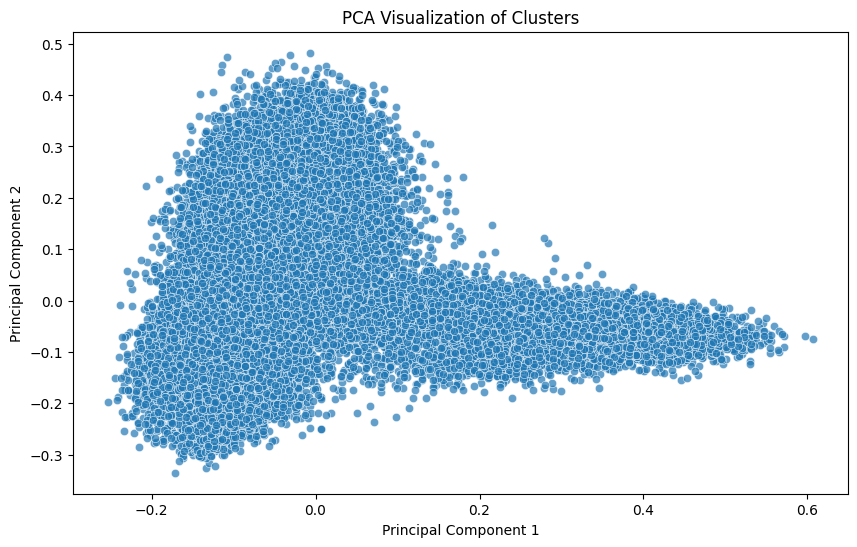

In [12]:
pca_features = apply_pca_and_visualize(features=tfidf_matrix, n_components=2)

In [ ]:
from sklearn.decomposition import PCA
import numpy as np
import pandas as pd

def apply_pca(features, n_components):
    """
    Applies PCA to reduce dimensionality of the dataset.

    Parameters:
    - features (np.ndarray): The high-dimensional feature matrix >> takes it Dense Not sparse.
    - n_components (int): Number of PCA components (default: 2).

    Returns:
    - pca_result (np.ndarray): Transformed feature representation.
    """
    pca = PCA(n_components=n_components,svd_solver='auto')
    pca_result = pca.fit_transform(features)
    return pca_result

In [42]:
pcaaaaa_features = apply_pca(features=tfidf_matrix.toarray(), n_components=50)

In [29]:
x = tfidf_matrix.toarray()

In [68]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

def visualize_pca(pca_result, labels=None, n_components=2):
    """Visualizes PCA results in 2D or 3D with hue (color coding)."""
    
    df_pca = pd.DataFrame(pca_result[:, :n_components], columns=[f"PC{i+1}" for i in range(n_components)])
    
    if labels is not None:
        df_pca["Cluster"] = labels
    
    plt.figure(figsize=(10, 6))

    if n_components == 2:
        sns.scatterplot(x="PC1", y="PC2", hue="Cluster" if labels is not None else None, 
                        data=df_pca, palette="tab10", alpha=0.7)
        plt.xlabel("PC1")
        plt.ylabel("PC2")

    elif n_components == 3:
        from mpl_toolkits.mplot3d import Axes3D
        fig = plt.figure(figsize=(10, 7))
        ax = fig.add_subplot(111, projection='3d')
        scatter = ax.scatter(df_pca["PC1"], df_pca["PC2"], df_pca["PC3"], 
                             c=labels if labels is not None else "blue", cmap="tab10", alpha=0.7)
        ax.set_xlabel("PC1")
        ax.set_ylabel("PC2")
        ax.set_zlabel("PC3")

        # Add a legend
        if labels is not None:
            legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
            ax.add_artist(legend1)

    plt.title(f"PCA Visualization ({n_components}D)")
    plt.show()


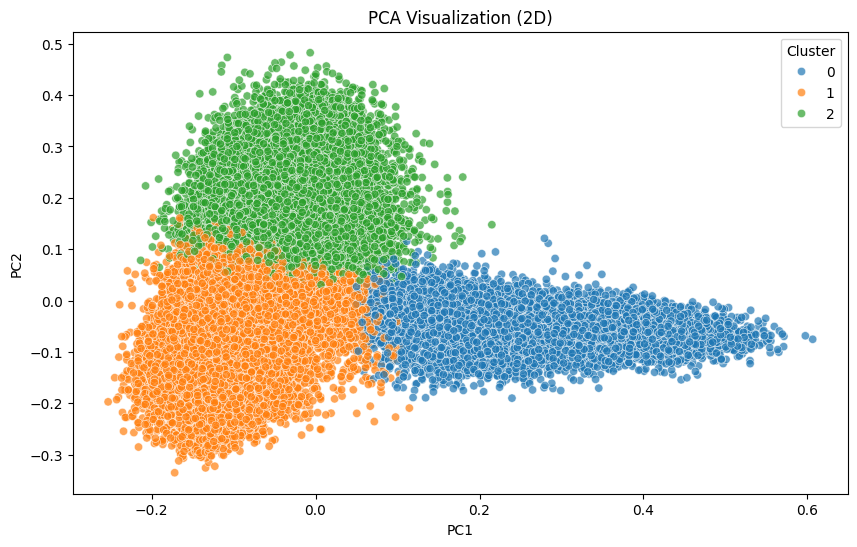

In [72]:
visualize_pca(pcaaaaa_features,labels=clusters, n_components=2)

c:\Users\aliay\OneDrive\Desktop\Github-zone\Text-Clustering-Project\env\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\aliay\OneDrive\Desktop\Github-zone\Text-Clustering-Project\env\lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "C:\Users\aliay\AppData\Local\Programs\Python\Python39\lib\subprocess.py", line 501, in run
    with Popen(*popenargs, **kwargs) as process:
  File "C:\Users\aliay\AppData\Local\Programs\Python\Python39\lib\subprocess.py", line 947, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\aliay\AppData\Local\Pr

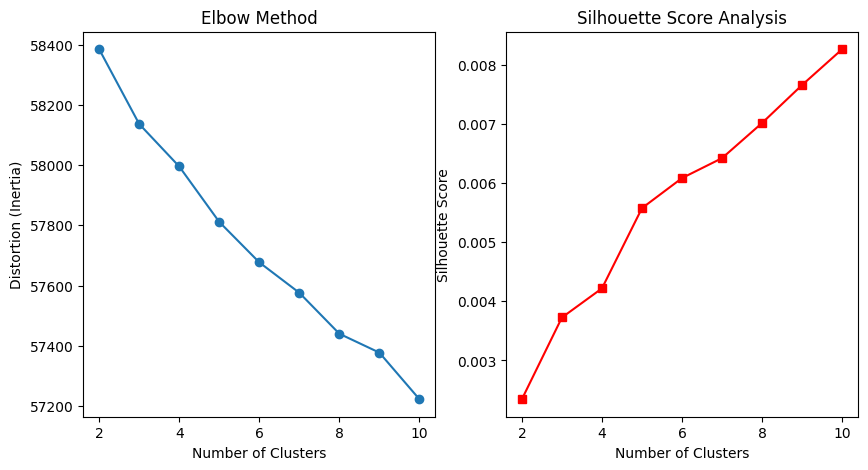

In [16]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

def elbow_method(features, max_k=10):
    """
    Applies the Elbow Method to find the optimal number of clusters.

    Parameters:
    - features (np.ndarray): The feature matrix (TF-IDF, Word2Vec, etc.).
    - max_k (int): The maximum number of clusters to test.

    Returns:
    - None (Displays Elbow plot).
    """
    distortions = []
    silhouette_scores = []
    K_range = range(2, max_k + 1)

    for k in K_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(features)
        distortions.append(kmeans.inertia_)
        silhouette_scores.append(silhouette_score(features, kmeans.labels_))

    # Plot the Elbow Method
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(K_range, distortions, marker='o')
    plt.xlabel("Number of Clusters")
    plt.ylabel("Distortion (Inertia)")
    plt.title("Elbow Method")

    # Plot Silhouette Score
    plt.subplot(1, 2, 2)
    plt.plot(K_range, silhouette_scores, marker='s', color='red')
    plt.xlabel("Number of Clusters")
    plt.ylabel("Silhouette Score")
    plt.title("Silhouette Score Analysis")

    plt.show()

# Example Usage:
elbow_method(tfidf_matrix)

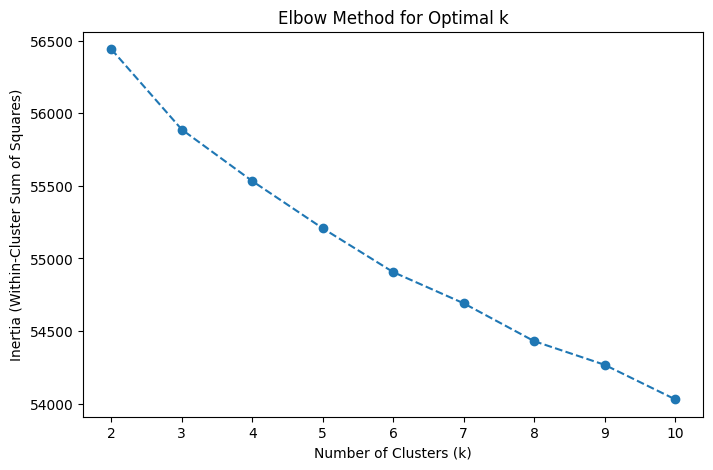

In [82]:
# %pip install matplotlib
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

def find_optimal_k(tfidf_matrix, max_k=10):
    inertia = []
    k_values = range(2, max_k + 1)

    for k in k_values:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(tfidf_matrix)
        inertia.append(kmeans.inertia_)

    # Plot the Elbow Curve
    plt.figure(figsize=(8, 5))
    plt.plot(k_values, inertia, marker='o', linestyle='--')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Inertia (Within-Cluster Sum of Squares)')
    plt.title('Elbow Method for Optimal k')
    plt.show()

# Run the function to find k
find_optimal_k(tfidf_matrix)


In [70]:
optimal_k = 3  # Set this based on the elbow curve result

kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
clusters = kmeans.fit_predict(pcaaaaa_features)

# Add cluster labels to the original DataFrame
# people_wiki_df["Cluster"] = clusters
# print(people_wiki_df[["text", "Cluster"]].head(10))  # Show first 10 results


In [44]:
# A) Silhouette Score
# Measures how well each document fits in its assigned cluster.

# Score ranges from -1 to 1:

# Close to 1 → Well-clustered

# Close to 0 → Overlapping clusters

# Close to -1 → Incorrect clustering

from sklearn.metrics import silhouette_score

silhouette_avg = silhouette_score(pcaaaaa_features, clusters)
print(f"Silhouette Score: {silhouette_avg:.4f}")


Silhouette Score: 0.1010


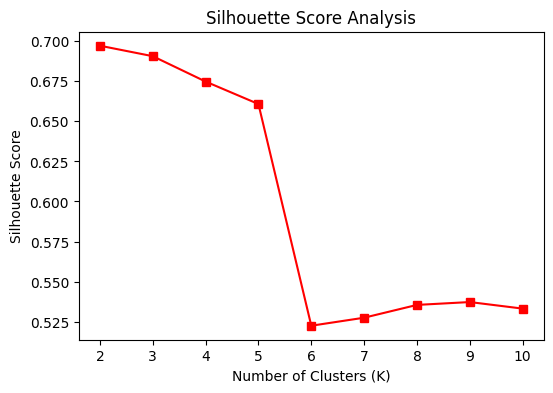

In [19]:
def plot_silhouette_scores(pca_features, max_k=10):
    """
    Plots the Silhouette Scores for different cluster values.
    
    Parameters:
    - features (np.ndarray): The feature matrix (TF-IDF, Word2Vec, etc.).
    - max_k (int): The maximum number of clusters to test.
    
    Returns:
    - None (Displays the Silhouette Score plot).
    """
    silhouette_scores = []
    K_range = range(2, max_k + 1)

    for k in K_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(pca_features)
        silhouette_scores.append(silhouette_score(pca_features, kmeans.labels_))

    # Plot Silhouette Score
    plt.figure(figsize=(6, 4))
    plt.plot(K_range, silhouette_scores, marker='s', linestyle='-', color='red')
    plt.xlabel("Number of Clusters (K)")
    plt.ylabel("Silhouette Score")
    plt.title("Silhouette Score Analysis")
    plt.show()

# Example Usage:
plot_silhouette_scores(pca_features)

In [ ]:
# Silhouette Score: 0.0168    >>> 7
# Silhouette Score: 0.0143   >>> 3
# Silhouette Score: 0.5   >>> 3 max_featues



In [74]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

def apply_lda(text_data, n_topics=3, max_features=5000):
    """
    Applies Latent Dirichlet Allocation (LDA) for topic modeling on text data.

    Parameters:
    - text_data (list or pd.Series): List of text documents.
    - n_topics (int): Number of topics to extract.
    - max_features (int): Maximum number of features for the CountVectorizer.

    Returns:
    - topic_distributions (np.ndarray): Document-topic matrix.
    - lda_model (LatentDirichletAllocation): Trained LDA model.
    - feature_names (list): Vocabulary terms.
    """
    
    # Convert text data into a bag-of-words representation
    vectorizer = CountVectorizer(stop_words='english', max_features=max_features)
    text_matrix = vectorizer.fit_transform(text_data)

    # Apply LDA
    lda_model = LatentDirichletAllocation(n_components=n_topics, random_state=42)
    topic_distributions = lda_model.fit_transform(text_matrix)

    return topic_distributions, lda_model, vectorizer.get_feature_names_out()



In [75]:
# lda_features, lda_model, lda_vocab = apply_lda(people_wiki_df["text"])
lda_features, lda_model, lda_vocab = apply_lda(people_wiki_df["text"], n_topics=3, max_features=5000)

print(lda_features.shape)

(59071, 3)


In [ ]:
# ) Davies-Bouldin Index
# Measures the compactness and separation of clusters.

# Lower values indicate better clustering.
from sklearn.metrics import davies_bouldin_score

db_score = davies_bouldin_score(tfidf_matrix.toarray(), clusters)
print(f"Davies-Bouldin Index: {db_score:.4f}")

In [73]:
from sklearn.metrics import davies_bouldin_score

def get_davies_bouldin_score(features, labels):
    """
    Computes the Davies-Bouldin Index for clustering.

    Parameters:
    - features (np.ndarray): The feature matrix.
    - labels (np.ndarray): Cluster labels.

    Returns:
    - float: Davies-Bouldin Index (lower is better).
    """
    return davies_bouldin_score(features, labels)

# Example Usage:
db_score = get_davies_bouldin_score(pcaaaaa_features, clusters)
print(f"Davies-Bouldin Index: {db_score:.4f}")

Davies-Bouldin Index: 2.8851


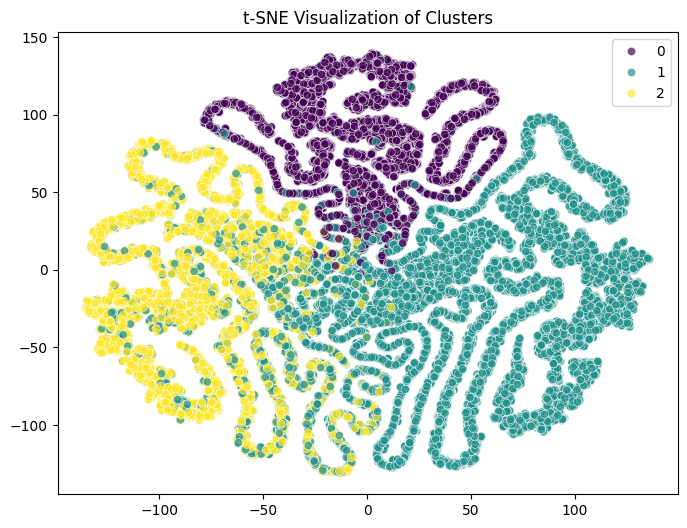

In [76]:
# %pip install seaborn
from sklearn.manifold import TSNE
import seaborn as sns

tsne = TSNE(n_components=2, random_state=42)
reduced_features = tsne.fit_transform(lda_features)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=reduced_features[:, 0], y=reduced_features[:, 1], hue=clusters, palette="viridis", alpha=0.7)
plt.title("t-SNE Visualization of Clusters")
plt.show()

<B>Trying Word2vec</B>

In [3]:
df_imported = pd.read_csv('data/preprocessed_people_wiki.csv')

In [4]:
df_imported

,text
0,digby morrell bear october australian rule foo...
1,alfred j lewy aka sandy lewy graduate universi...
2,harpdog brown singer harmonica player active c...
3,franz rottensteiner bear waidmannsfeld low aus...
4,henry krvit bear december tallinn well know st...
...,...
59066,olari elt bear april tallinn estonia estonian ...
59067,scott francis crago bear july twin brother jef...
59068,david william royce cass bear march forest gat...
59069,keith hector elias bear february lacey townshi...


In [50]:
# trying word2vec

import gensim.downloader as api

# Load the pretrained Google News Word2Vec model (takes time)
word2vec_model = api.load("word2vec-google-news-300")

# Check the vector for a sample word
# print(word2vec_model['king'])  # Example


In [51]:
# %pip uninstall numpy gensim -y
# %pip install numpy gensim
# Successfully installed gensim-4.3.3 numpy-1.26.4
# %pip install --force-reinstall --no-cache-dir numpy==1.23.5
# save the model 
# word2vec_model.save("word2vec-google-news-300.model")



In [52]:
import numpy as np

def document_vector(doc, model):
    """Compute the mean Word2Vec vector for a document."""
    words = [word for word in doc.split() if word in model]
    if not words:
        return np.zeros(model.vector_size)
    return np.mean([model[word] for word in words], axis=0)

# Apply to your dataset (assuming text column is 'text')
df_imported['embedding'] = df_imported['text'].apply(lambda x: document_vector(x, word2vec_model))

# Convert to matrix for clustering
X_word2vec = np.vstack(df_imported['embedding'].values)


In [53]:
from sklearn.cluster import KMeans

# Define number of clusters (use elbow method again if needed)
k = 3
kmeans = KMeans(n_clusters=k, random_state=42)
df_imported['cluster_word2vec'] = kmeans.fit_predict(X_word2vec)

# Check the results
print(df_imported[['text', 'cluster_word2vec']].head())


                                                text  cluster_word2vec
0  digby morrell bear october australian rule foo...                 1
1  alfred j lewy aka sandy lewy graduate universi...                 2
2  harpdog brown singer harmonica player active c...                 0
3  franz rottensteiner bear waidmannsfeld low aus...                 0
4  henry krvit bear december tallinn well know st...                 0


In [54]:
from sklearn.metrics import silhouette_score

# tfidf_matrix or word2vec_matrix (your feature matrix)
# cluster_labels (your model's predicted clusters)

score = silhouette_score(X_word2vec, df_imported['cluster_word2vec'])
print(f"Silhouette Score: {score:.4f}")


Silhouette Score: 0.1409


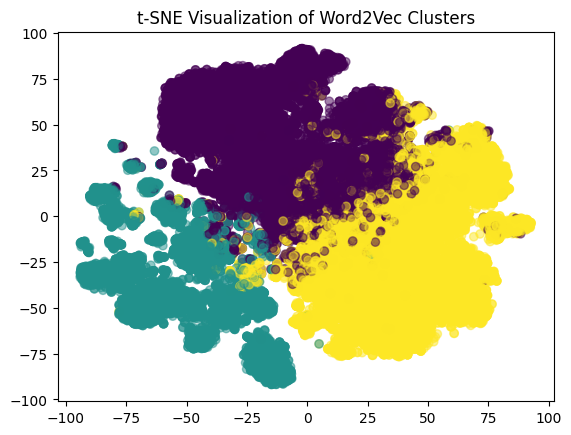

In [17]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Reduce dimensions
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_word2vec)

# Plot
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=df_imported['cluster_word2vec'], cmap='viridis', alpha=0.5)
plt.title("t-SNE Visualization of Word2Vec Clusters")
plt.show()


In [72]:
len(df_imported)

59071

In [82]:
# apply glove model
import spacy
nlp = spacy.load("en_core_web_sm")

sentences = [[token.text.lower() for token in nlp(text) if token.is_alpha] for text in df_imported["text"].dropna()]

In [ ]:
from gensim.models import Word2Vec

# Download pretrained GloVe embeddings (50D, 100D, 200D, or 300D available)
glove_vectors = api.load("glove-wiki-gigaword-300")  # 300-dimensional embeddings

# Initialize Word2Vec model with same vector size as GloVe
word2vec_model = Word2Vec(vector_size=300, window=5, min_count=1, workers=4)

# Build vocabulary from new dataset
word2vec_model.build_vocab(sentences)

# Initialize model weights using GloVe embeddings
common_words = list(set(word2vec_model.wv.index_to_key) & set(glove_vectors.index_to_key))

for word in common_words:
    word2vec_model.wv[word] = np.copy(glove_vectors[word])

# Train (fine-tune) on new dataset
word2vec_model.train(sentences, total_examples=len(sentences), epochs=5)

# Save the updated model
word2vec_model.save("fine_tuned_glove.model")

# Load it later
fine_tuned_glove = Word2Vec.load("fine_tuned_glove.model")

[==================================================] 100.0% 376.1/376.1MB downloaded


In [ ]:
from gensim.models import Word2Vec
# Load it later
fine_tuned_glove = Word2Vec.load("fine_tuned_glove.model")

FileNotFoundError: [Errno 2] No such file or directory: 'fine_tuned_glove.model'

: 

In [1]:
# Function to convert a sentence into a vector (mean of word embeddings)
def sentence_vector(sentence, model):
    words = [word for word in sentence if word in model]
    if words:
        return np.mean([model[word] for word in words], axis=0)
    else:
        return np.zeros(model.vector_size)  # Handle empty cases

# Convert all sentences to vectors
sentence_vectors = np.array([sentence_vector(sentences, fine_tuned_glove) for sent in sentences])

NameError: name 'np' is not defined

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np

# Define the number of clusters (choose an optimal value later)
num_clusters = 3

# Apply K-Means
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(sentence_vectors)

# Get cluster labels for each text row
df_imported["cluster"] = kmeans.labels_

# Print first 10 rows with assigned clusters
print(df_imported.head(10))



In [ ]:
from sklearn.metrics import silhouette_score

# Compute Silhouette Score
silhouette_avg = silhouette_score(sentence_vectors, kmeans.labels_)
print(f"Silhouette Score: {silhouette_avg:.4f}")
